As it is difficult to test the accuracy of the algorithm in the Los Alamos dataset, we will create a artificial dataset for this purpose. A mixture of distributions will denote the possible states each host can be part of for each individual epoch. 

A set of different clusters of hosts will be created. Each set will have hosts, whose points are generated through the same transition matrices.

First we define the states that each data points can be part of. We will use a two dimensional space and a total of 7 total distributions.

In [1]:
import numpy as np

lambdas = np.vstack([[0,0], [15,20], [37,12], [7,48], [55,75], [30,40], [35,25]])
# set the weights of each distributions the same
weights = np.array([1/len(lambdas)] * len(lambdas))

# get random samples from these distributions
# number of points to take from each distribution centroid
size = 1000

for i, lambda_i in enumerate(lambdas):
    s1 = np.random.poisson(lambda_i[0], size)
    s2 = np.random.poisson(lambda_i[1], size)

    if i == 0:
        data = np.column_stack((s1, s2, np.array([i]*size, dtype=object)))
    else:
        data = np.append(data, np.column_stack((s1, s2, np.array([i]*size, dtype=object))), axis=0)

np.random.shuffle(data)

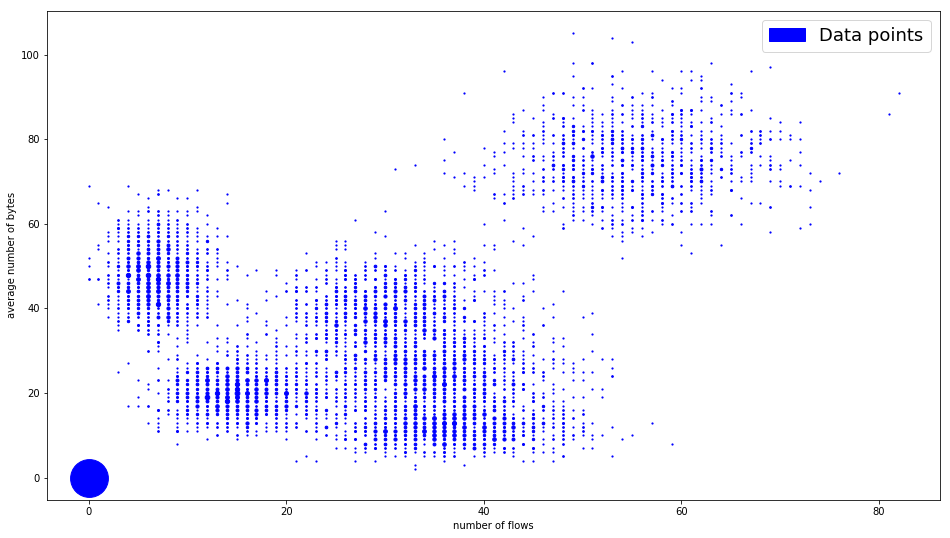

In [2]:
from plots import plot_points
%matplotlib inline

plot_points(data[:, :2])

As we can see most of these cluster are clearly seperated. Some of them are not. This is done on purpose to simulate a real example. From the random samples generated above, we can found the probability that a random sample has the maximum mass function value, for the distribution it originated from.

Let K be the total number of the distributions and J the total number of features we are considering (in our case 2).

Then for the $i^{th}$ sample drawn from the distribution k, the most likely distribution it originated from would be:

$$k_i = \underset{k}{\operatorname{argmax}} f(x_i, l_k)$$

where $$f(x_i, l_k) = \prod_{j=1}^J \frac{(l_{kj})^{x_{ij}} e^{-l_{kj}}}{x_{ij}!}$$

In [3]:
import scipy.stats.distributions


def poisson(x, l):
    return_value = 1
    for x_i, l_i in zip(x, l):
        return_value *= scipy.stats.distributions.poisson.pmf(x_i, l_i)
    return return_value

predictions = []
true_classes = []
for point in data:
    classification = np.argmax([poisson(point[:2], lambda_i) for lambda_i in lambdas])
    predictions.append(classification)
    true_classes.append(point[2])

In [4]:
from sklearn.metrics import classification_report, confusion_matrix

target_names = ['class ' + str(i) for i in range(len(lambdas))]
print('confusion_matrix: ')
print(confusion_matrix(true_classes, predictions))

print()
print()
print(classification_report(true_classes, predictions, target_names=target_names))

confusion_matrix: 
[[1000    0    0    0    0    0    0]
 [   0  968    8    4    0    5   15]
 [   0    8  941    0    0    0   51]
 [   0    2    0  997    0    1    0]
 [   0    0    0    0  998    2    0]
 [   0    6    0    2    3  905   84]
 [   0   14   81    0    0   88  817]]


             precision    recall  f1-score   support

    class 0       1.00      1.00      1.00      1000
    class 1       0.97      0.97      0.97      1000
    class 2       0.91      0.94      0.93      1000
    class 3       0.99      1.00      1.00      1000
    class 4       1.00      1.00      1.00      1000
    class 5       0.90      0.91      0.90      1000
    class 6       0.84      0.82      0.83      1000

avg / total       0.95      0.95      0.95      7000



Now we will create the clusters of the transition matrices.

We will create a number of clusters containing different number of hosts each to stimulate a real example.

The parameter L denotes the total number of these matrices clusters.

In [5]:
import random as ran

L = 9
num_hosts_per_L = [20, 25, 50, 55, 60, 70, 80, 100, 150]

def random_vector(size=7):
    vec = [ran.random() for i in range(size)]
    return np.array(vec) / sum(vec)

def random_transition_matrix(size=7):
    return np.vstack([random_vector(size=size) for i in range(size)])

In [6]:
transition_matrices = []
for i in range(L):
    transition_matrices.append(random_transition_matrix(size=len(lambdas)))

Create the points for each individual host.

Each host, for the first epoch, has a datapoints at a random distribution. The next datapoint will belong to a new distribution depending on a roulette wheel mechanism and the transition probabilities of the cluster the host belongs to.

In [7]:
data_points = []
number_of_epochs = 500

# creates a random data point for a specified distribution and adds it to the total data points
def add_random_points(data_points, host_name, distribution, lambdas, epoch):
    axis0 = np.random.poisson(lambdas[distribution][0], 1)[0]
    axis1 = np.random.poisson(lambdas[distribution][1], 1)[0]
    data_points.append([axis0, axis1, epoch, host_name])

def random_next_state(transition_matrices, i, previous_distribution):
    r = ran.random()
    return np.where(transition_matrices[i][previous_distribution].cumsum() >= r)[0][0]
    
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        # random starting distribution
        previous_distribution = ran.randint(0, len(lambdas) - 1)
        add_random_points(data_points, host_name, previous_distribution, lambdas, 1)
        
        for k in range(2, number_of_epochs + 1):
            next_distribution = random_next_state(transition_matrices, i, previous_distribution)
            
            add_random_points(data_points, host_name, next_distribution, lambdas, k)
            
            previous_distribution = next_distribution
            

data_points = np.array(data_points,  dtype=object)

Run the EM Algorithm and the clustering

An important note is that initial EM mixtures center points, might have some differences to the desired final points, so on the starting epochs some of the results might not be the desired ones. This should not be a problem though.

In [8]:
from emClustering import OnlineEM
from plots import plot_points, plot_results, plot_category, plot_all_categories
from kplusplus import KPlusPlus
import numpy as np
import pandas as pd

Select some random data points as the initial ones.

In [13]:
mixtures = len(lambdas)

kplusplus = KPlusPlus(mixtures, data_points[:, :2], stochastic=True, stochastic_n_samples=10000)

kplusplus.init_centers(verbose=1)

Centers found: 1
Centers found: 2
Centers found: 3
Centers found: 4
Centers found: 5
Centers found: 6
Centers found: 7


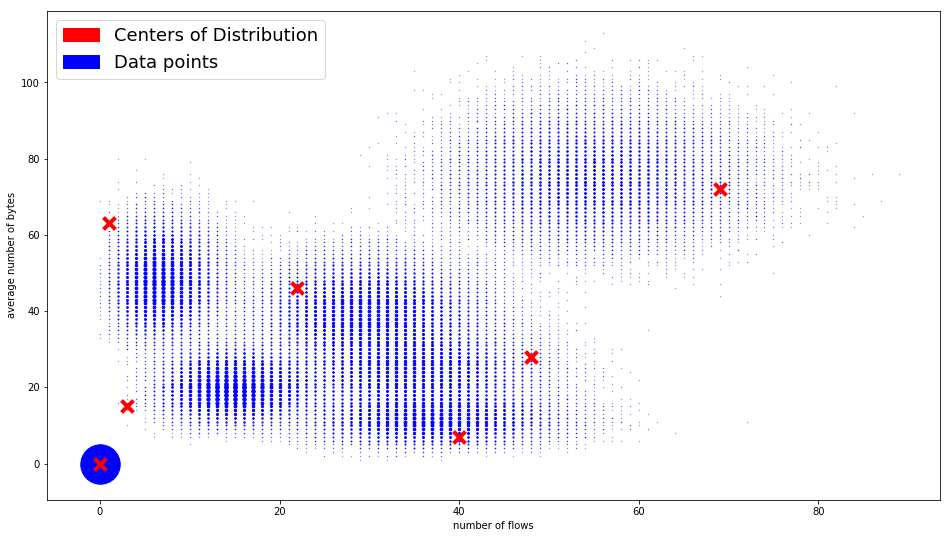

In [14]:
onlineEM = OnlineEM([1/mixtures]*mixtures, kplusplus.centers, sum(num_hosts_per_L), verbose=0, update_power=0.5)

# the initial data points
plot_points(data_points[:, :2], onlineEM)

In [15]:
onlineEM.fit(data_points[:,[0,1,3]])

D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:205: RuntimeWarning: invalid value encountered in true_divide
  previous)
D:\Sotiris\Projects\JupyterNotebooks\onlineAnomalyDetection\diploma\emClustering.py:209: RuntimeWarning: invalid value encountered in true_divide
  previous)


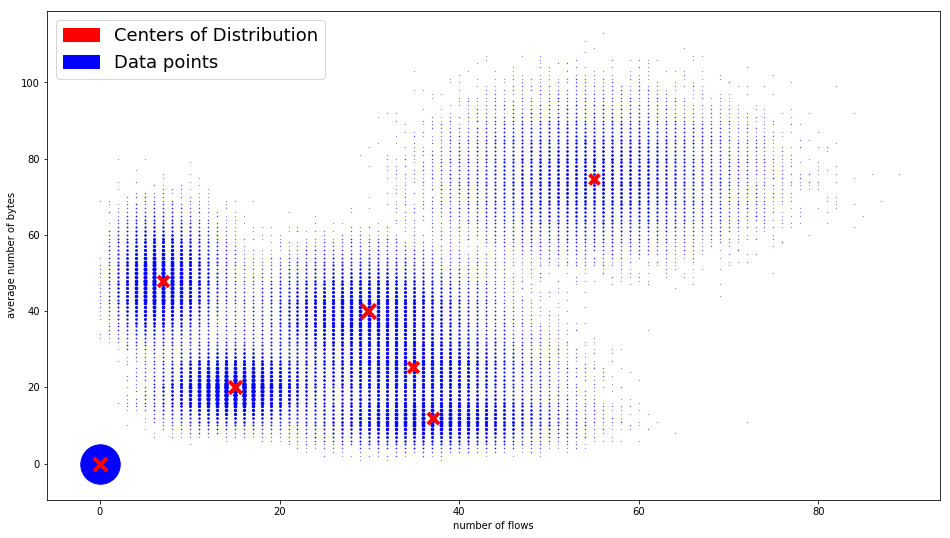

In [16]:
# the final data points
plot_points(data_points[:, :2], onlineEM)

In [17]:
print(onlineEM.gammas)
print(onlineEM.lambdas)

[ 0.20940801  0.177099    0.09985206  0.12695973  0.15745559  0.11518068
  0.11404494]
[[29.903453004406249 39.924852367704972]
 [0.0 0.0]
 [55.030419543720754 74.747034556717949]
 [37.104916018657278 11.983854486326976]
 [15.042166660234827 20.014150783085629]
 [6.9906293607623473 48.004517895689929]
 [34.87760138905746 25.342596365755359]]


The transition matrices will be initialized to the following table (normalized to 1):

initializer:

|  |
| :-------------: |:-------------:| :-----:|
| 1  | 0.5 | ... | 0.5 | 
| 0.5  | 1 | ... | 0.5 | 
| ...  | ... | ... | .. | 
| 0.5  | 0.5 | ... | 1 | 


The final transition matrix will be:

$$\frac{initializer}{num\_points + 1} + \frac{transition\_matrix * num\_points}{num\_points + 1}$$ for each individual row.

This is done manually in the following cells but in the final version of the algorithm will be done automatically

In [18]:
import numpy as np

m = onlineEM.m

initialize = np.eye(m)

for i in range(m):
    for j in range(m):
        if i != j:
            initialize[i][j] = 0.5
            
    initialize[i] /= (1 + 0.5 * (m - 1))

In [19]:
for host in onlineEM.hosts:
    tm = onlineEM.hosts[host]['transition_matrix']
    for i, points in enumerate(onlineEM.hosts[host]['points_per_cluster']):
        tm[i] = tm[i] * (points / (points + 1)) + initialize[i] / (points + 1)

Now we can cluster the transition matrices.

In [21]:
from klkmeans import kl_kMeans

kmeans = kl_kMeans(onlineEM, n_clusters=L, initial_centers=None, n_iters=15, n_runs=10)
C, assign = kmeans.run()

Starting run
The cost is 24.9716907952
The cost is 16.7872515973
The cost is 14.6039901858
converged
Starting run
The cost is 24.0876332115
The cost is 16.6267898187
The cost is 16.6209378237
The cost is 16.6195795864
converged
Starting run
The cost is 26.5232172964
The cost is 14.9215178974
The cost is 13.8399208025
converged
Starting run
The cost is 30.0977136922
The cost is 20.1162537514
The cost is 19.3956033376
converged
Starting run
The cost is 30.6385675886
The cost is 19.2511178768
The cost is 17.9461289421
The cost is 17.8869702609
The cost is 17.8806951628
The cost is 17.8737832262
The cost is 17.8719650938
The cost is 17.8713102788
The cost is 17.8707764623
converged
Starting run
The cost is 27.3013346386
The cost is 17.1797359703
The cost is 16.9248354306
The cost is 16.9094724536
The cost is 16.9026323043
The cost is 16.9004619408
The cost is 16.8974904549
The cost is 16.8966457892
converged
Starting run
The cost is 24.0150092398
The cost is 15.6139586887
The cost is 13.82

In [22]:
centroids = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = assign[host_name]
        centroids[i][participation] += 1
    
print(centroids)

[[  0   0   0   0   0  20   0   0   0]
 [  0   0   0   0   0   0  25   0   0]
 [  0  50   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0  55   0]
 [  0   0   0   0   0   0   0   0  60]
 [ 70   0   0   0   0   0   0   0   0]
 [  0   0   0  80   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0]
 [  0   0   0   0 150   0   0   0   0]]


Calculate the Purity

$$ Purity = \frac{1}{N} \sum_{i=1}^k max_j |c_i ∩ t_j|$$

where $c_i$ is the class the host belongs to and $t_j$ the cluster it was assigned to

In [26]:
total = sum(num_hosts_per_L)

pure = np.sum(np.max(centroids, axis=1))

print('Purity if the clusters is', pure/total)

Purity if the clusters is 1.0


We will now compare this method to merely classifying hosts based on the clusters their data points can be found

For this case we will cluster the vectors containing for each host where their points can be located

In [27]:
participations = []
for host in onlineEM.hosts:
    participations.append(onlineEM.hosts[host]['points_per_cluster'])

In [29]:
from sklearn.cluster import KMeans

kmeans_points = KMeans(n_clusters=L, random_state=0).fit(participations)

In [33]:
centroids_points = np.zeros(shape=(L, L), dtype=np.int64)
for i in range(L):
    for j in range(num_hosts_per_L[i]):
        host_name = 'centroid-' + str(i) + '-host-' + str(j)
        
        participation = kmeans_points.predict([onlineEM.hosts[host_name]['points_per_cluster']])[0]
        centroids_points[i][participation] += 1
    
print(centroids_points)

[[  0   0   0   0   0   0   0   0  20]
 [  0   0   0   0   0   0   0   0  25]
 [  0   0   0   0   0  50   0   0   0]
 [  0   0   0   0  55   0   0   0   0]
 [  0   0   0   0   0   0   0  60   0]
 [ 13   0   0  25   0   0  32   0   0]
 [  0  80   0   0   0   0   0   0   0]
 [  0   0 100   0   0   0   0   0   0]
 [ 42   0   0  60   0   0  48   0   0]]


In [35]:
total = sum(num_hosts_per_L)

pure = np.sum(np.max(centroids_points, axis=1))

print('Purity if the clusters is', pure/total)

Purity if the clusters is 0.790163934426
